In [268]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

### **1. Solvers (Solucionadores)**

Un solucionador aplica un método numérico para resolver el conjunto de ecuaciones diferenciales ordinarias que representan el modelo.  
Existen dos tipos de solucionadores: **solucionadores de tamaño de paso fijo** y **solucionadores de tamaño de paso adaptable**.

**Solucionadores de tamaño de paso fijo** resuelven el modelo utilizando el mismo tamaño de paso desde el inicio hasta el final de la simulación. Generalmente, un tamaño de paso pequeño aumenta la precisión de los resultados, pero también incrementa el tiempo requerido para simular el sistema.

**Solucionadores de tamaño de paso adaptable** varían el tamaño de paso durante la simulación. Estos solucionadores reducen el tamaño de paso para aumentar la precisión en ciertos eventos durante la simulación del modelo, como cambios rápidos de estado, eventos de cruce por cero, etc. Asimismo, aumentan el tamaño de paso para evitar realizar pasos innecesarios cuando los estados del modelo cambian lentamente.


#### **Solucionador de Euler**  
El método de Euler es uno de los algoritmos más antiguos y simples.  
La idea principal consiste en aproximar la función solución paso a paso utilizando líneas tangentes.

Aquí, vamos a crear una nueva función que calcule `euler_step`.  

**Método de Euler**  

Cuando $\frac{dy}{dt} = f(t, y)$ y $y(t_0) = y_0$, entonces $y_t = y_0 + f(t_0, y_0)(t-t_0)$  

In [269]:
# func: representa la EDO del sistema, f(t,y), una función que regresa la derivada dy/dt
# t: el tiempo actual
# dt: tamaño del paso
# y: el estado actual del sistema en el tiempo t

def euler(func, t, dt, y):
    return dt * func(t, y)

Método de Runge-Kutta



In [270]:
def rk4(func, t, dt, y):
  half_dt = dt * 0.5

  k1 = func(t, y)
  k2 = func(t + half_dt, y + half_dt * k1)
  k3 = func(t + half_dt, y + half_dt * k2)
  k4 = func(t + dt, y + dt * k3)
  
  return (k1 + 2 * (k2 + k3) + k4) * dt * 1/6

# 2. Neural ODEs


Aquí implementamos el "forward pass".

In [271]:
# Neural ODE model
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty((len(t), *y0.shape), dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      dy = solver(self.func, t0, t1 - t0, y0)
      y1 = y0 + dy
      solution[j] = y1
      j += 1
      y0 = y1
    return solution

# 3. Comprobar funcionamiento de clase NeuralODE

Si consideramos la derivada como cos(t), el resultado deberá ser sin(t)

In [272]:
y0 = torch.Tensor([[0]]).cuda()
t = torch.linspace(0., 6*np.pi, 1500).cuda()

class cos(nn.Module):
  def forward(self, t, y):
    return torch.cos(t)

In [273]:
ode_test = NeuralODE(func=cos()).cuda()
test_result = ode_test(y0=y0, t=t, solver=euler)

# hacer transpuesta
test_result = test_result.transpose(0, 1)

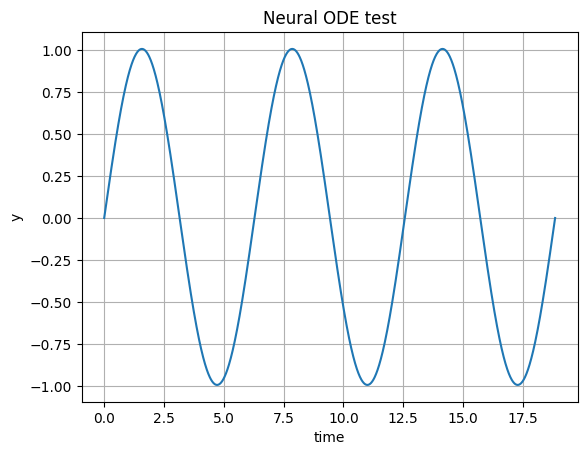

In [274]:
# Graficar (obtenemos función sin)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')
ax.set_xlabel('time')
ax.set_ylabel('y')
ax.plot(t.cpu().numpy(), test_result[0].detach().cpu().numpy())
plt.grid(True)
plt.show()

3.2 Conjunto de datos: Spiral
Conjunto de datos de experimentación (toy dataset) 

In [275]:
data_size = 2000

In [276]:
# generar datos de experimentación
true_y0 = torch.tensor([[2., 0.]]).cuda()
t = torch.linspace(0., 25., data_size).cuda()
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).cuda()

class Lambda(nn.Module):
  def forward(self, t, y):
    return torch.mm(y**3, true_A)

with torch.no_grad():
  node = NeuralODE(func=Lambda()).cuda()
  true_y = node(y0=true_y0, t=t, solver=rk4)

In [277]:
(true_y0).shape

torch.Size([1, 2])

In [278]:
torch.mm(true_y0**3, true_A)

tensor([[-0.8000, 16.0000]], device='cuda:0')

In [279]:
true_A.dim()

2

In [280]:
true_y

tensor([[[ 2.0000,  0.0000]],

        [[ 1.9900,  0.1986]],

        [[ 1.9795,  0.3942]],

        ...,

        [[-0.4427,  0.2839]],

        [[-0.4432,  0.2817]],

        [[-0.4436,  0.2794]]], device='cuda:0')

In [281]:
true_A

tensor([[-0.1000,  2.0000],
        [-2.0000, -0.1000]], device='cuda:0')

In [282]:
true_y.shape

torch.Size([2000, 1, 2])

In [283]:
true_y.shape

torch.Size([2000, 1, 2])

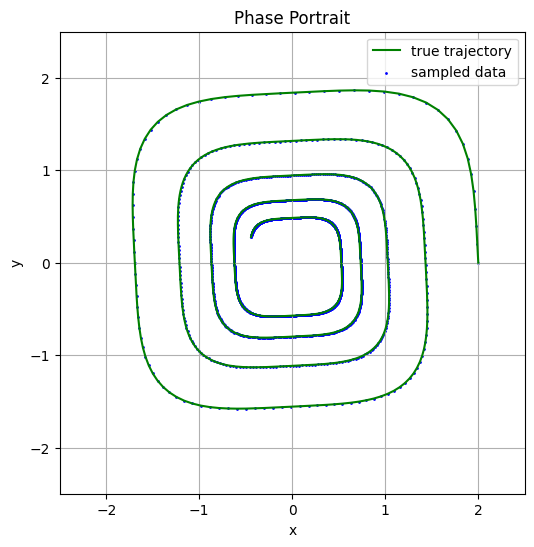

In [284]:
def visualize(true_y, pred_y=None):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_title('Phase Portrait')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'green', label='true trajectory')
  ax.scatter(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], color='blue', label='sampled data', s=1)
  if pred_y is not None:
    ax.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'red', label='learned trajectory')
  ax.set_xlim(-2.5, 2.5)
  ax.set_ylim(-2.5, 2.5)
  plt.legend()
  plt.grid(True)
  plt.show()

visualize(true_y)

In [285]:
t.shape

torch.Size([2000])

Generar lotes (batches)

In [286]:
batch_time = 10
batch_size = 16

def get_batch():
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
  batch_y0 = true_y[s]  # (batch_size, 1, emb)
  batch_t = t[:batch_time]  # (T)
  batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
  return batch_y0.cuda(), batch_t.cuda(), batch_y.cuda()

In [300]:
batch_y0.shape, batch_t.shape, batch_y.shape

(torch.Size([16, 1, 2]), torch.Size([10]), torch.Size([10, 16, 1, 2]))

Capa Fully Connected para parametriz la dinámica del sistema

In [303]:
# Define la dinámica del sistema
class ODEFunc(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Tanh(),
                             nn.Linear(50, 2))
    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y**3)
    return output

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 0.753718


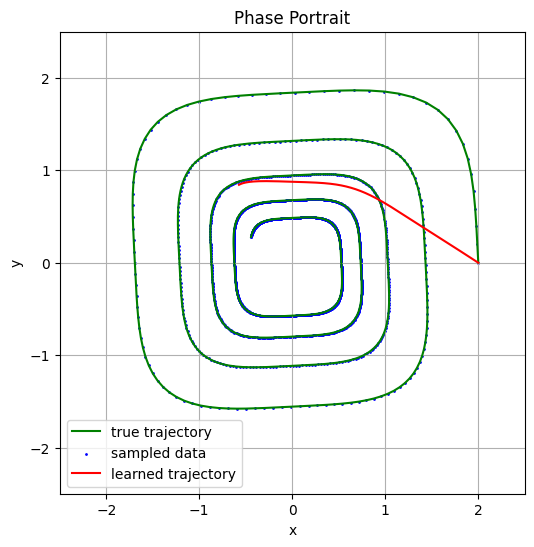

 12%|█▏        | 47/401 [00:01<02:56,  2.01it/s]

Iter 0050 | Total Loss 0.505619


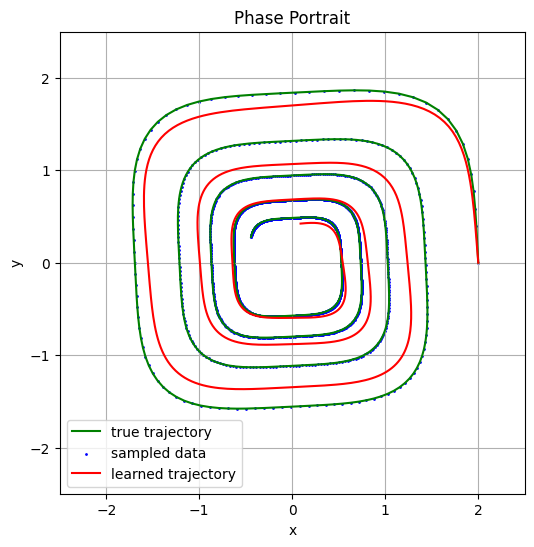

 21%|██▏       | 86/401 [00:03<01:01,  5.09it/s]

Iter 0100 | Total Loss 0.416124


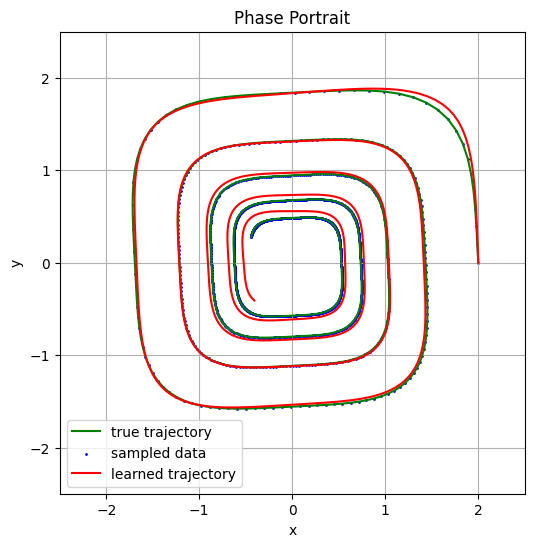

 36%|███▌      | 144/401 [00:05<00:15, 16.16it/s]

Iter 0150 | Total Loss 0.880160


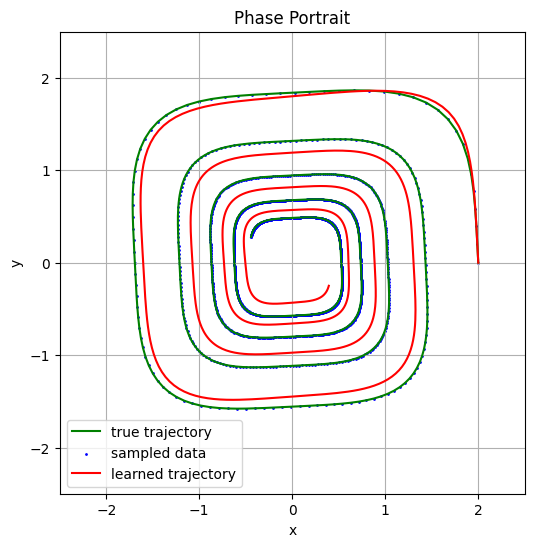

 50%|████▉     | 200/401 [00:07<00:06, 30.69it/s]

Iter 0200 | Total Loss 0.817850


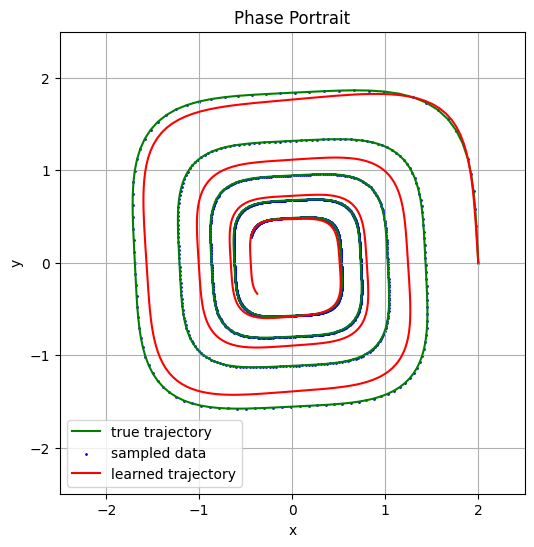

 60%|██████    | 242/401 [00:08<00:05, 31.07it/s]

Iter 0250 | Total Loss 0.594311


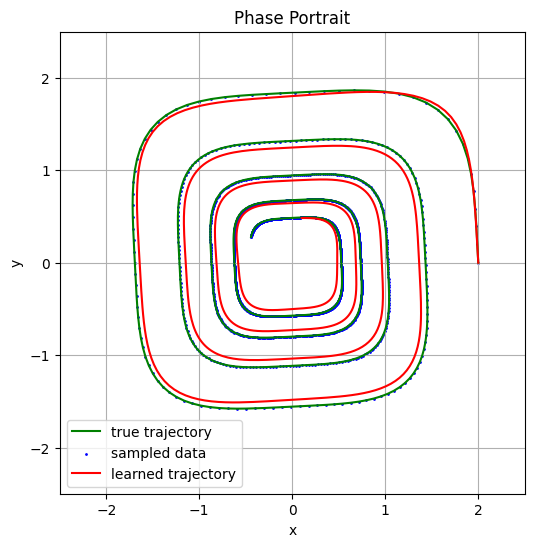

 72%|███████▏  | 287/401 [00:10<00:03, 31.35it/s]

Iter 0300 | Total Loss 0.863830


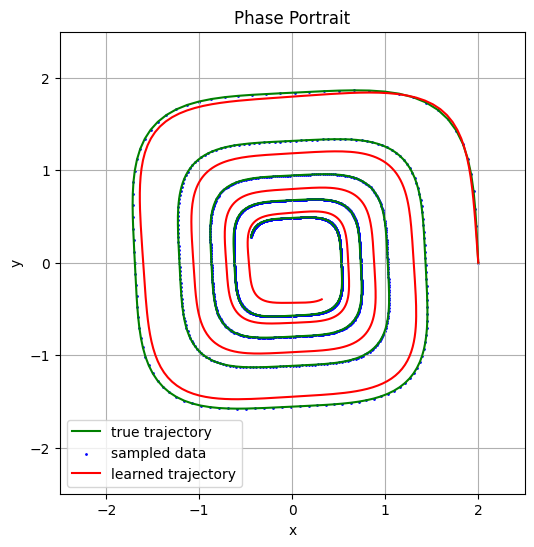

 86%|████████▋ | 346/401 [00:12<00:01, 42.88it/s]

Iter 0350 | Total Loss 0.857853


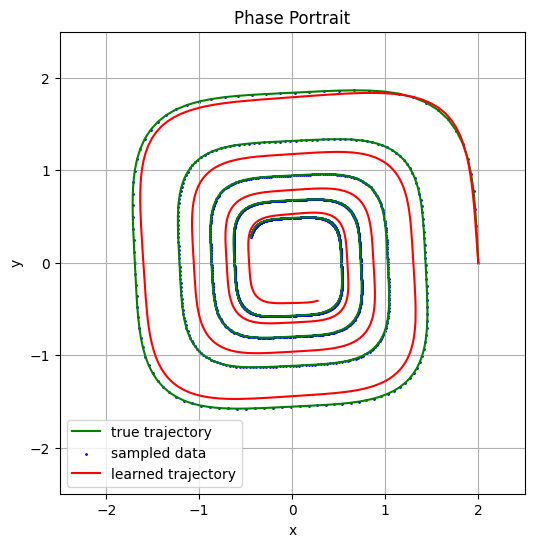

 98%|█████████▊| 391/401 [00:13<00:00, 35.62it/s]

Iter 0400 | Total Loss 0.851528


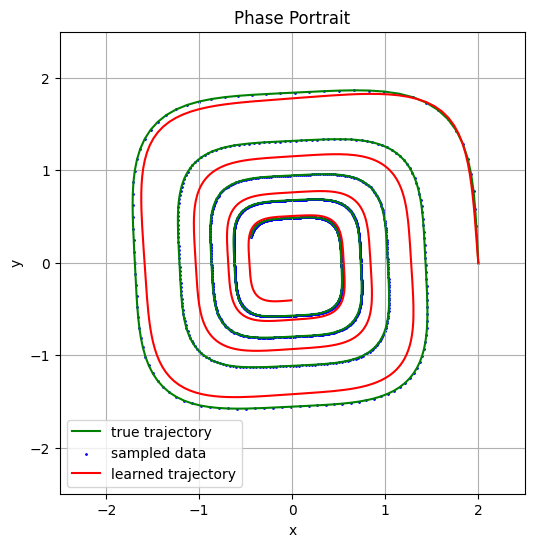

100%|██████████| 401/401 [00:15<00:00, 26.00it/s]

process time: 15.426504611968994 sec


In [288]:
## Train
niters = 400

node = NeuralODE(func=ODEFunc()).cuda()
optimizer = optim.RMSprop(node.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = node(y0=batch_y0, t=batch_t, solver=euler)
  # MAE Loss
  loss = torch.mean(torch.abs(pred_y - batch_y)) 
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = node(true_y0, t, solver=rk4)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

# 4. Experiments

4-1. Comparison with Adaptive Solvers

In [289]:
from torchdiffeq import odeint

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 7.051346


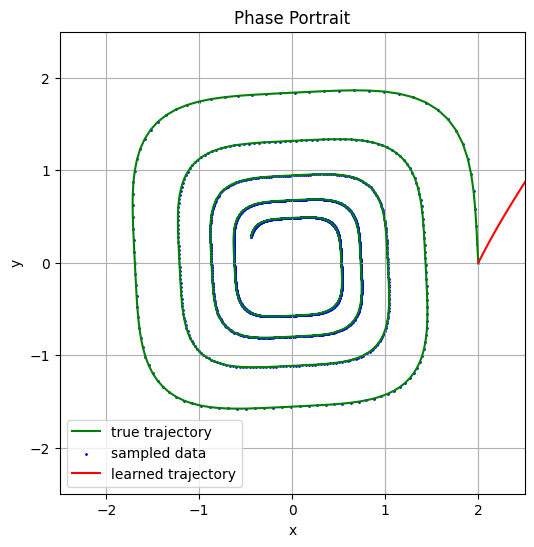

 12%|█▏        | 49/401 [00:02<00:34, 10.23it/s]

Iter 0050 | Total Loss 0.561775


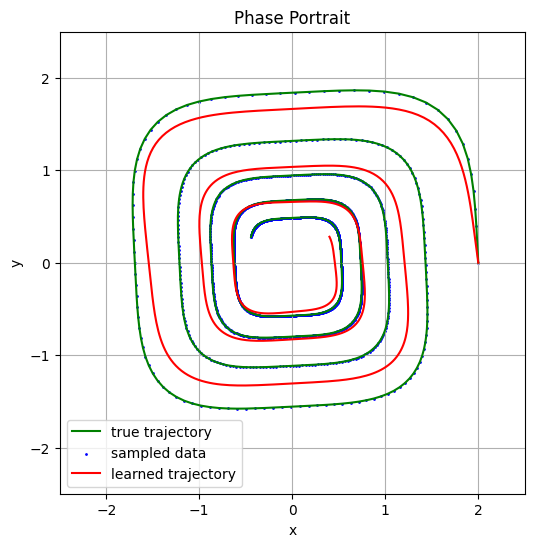

 24%|██▍       | 97/401 [00:04<00:08, 35.73it/s]

Iter 0100 | Total Loss 0.528189


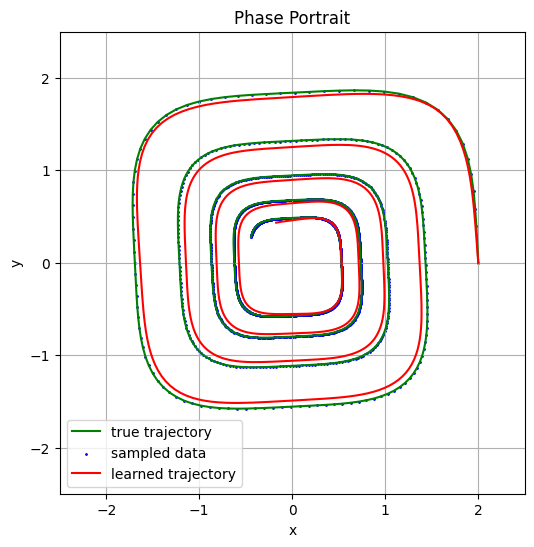

 36%|███▌      | 145/401 [00:06<00:06, 40.85it/s]

Iter 0150 | Total Loss 0.438960


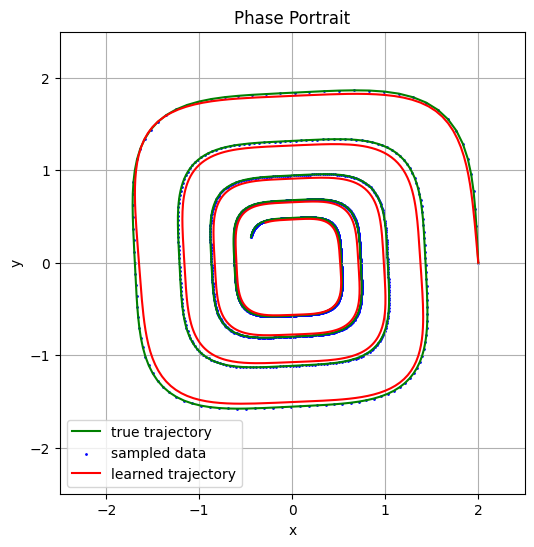

 50%|████▉     | 199/401 [00:09<00:04, 45.31it/s]

Iter 0200 | Total Loss 0.382865


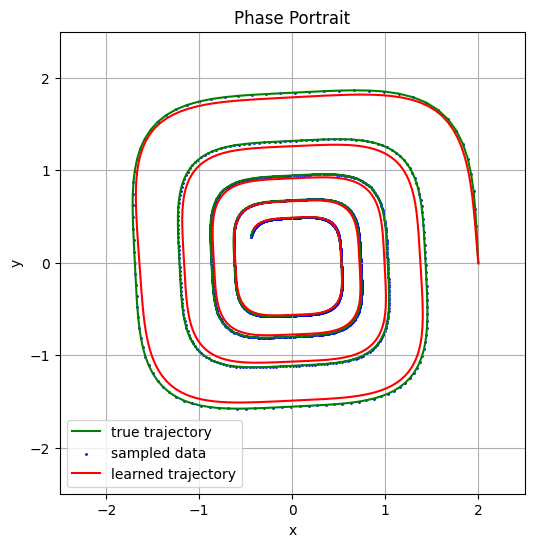

 62%|██████▏   | 247/401 [00:11<00:03, 40.88it/s]

Iter 0250 | Total Loss 0.297835


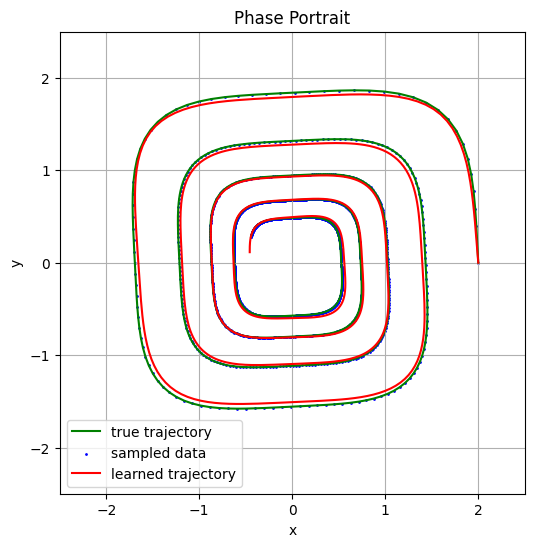

 75%|███████▍  | 300/401 [00:13<00:02, 45.53it/s]

Iter 0300 | Total Loss 0.559925


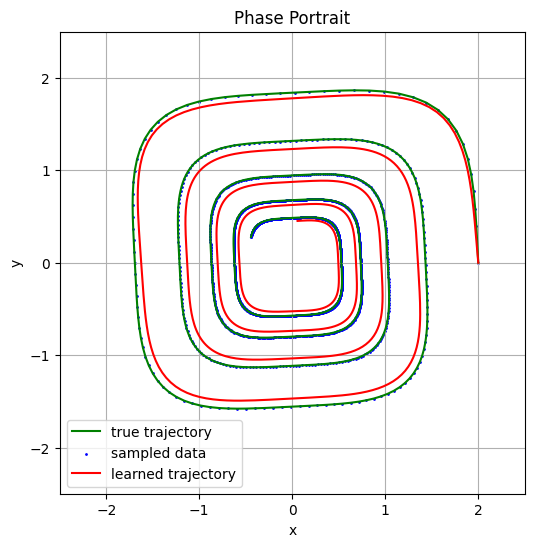

 87%|████████▋ | 348/401 [00:15<00:01, 40.38it/s]

Iter 0350 | Total Loss 0.398302


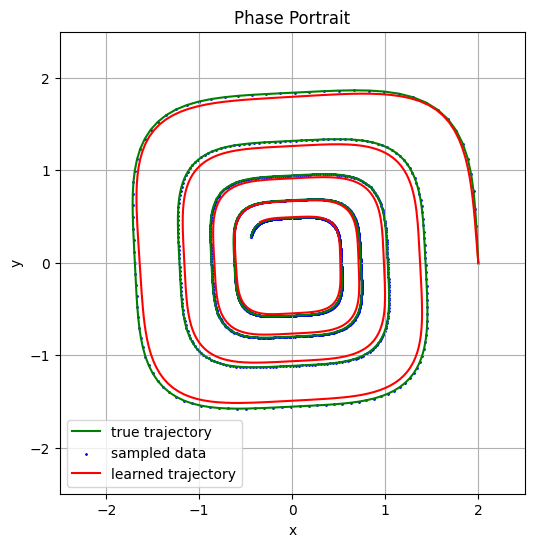

 99%|█████████▉| 396/401 [00:18<00:00, 40.96it/s]

Iter 0400 | Total Loss 0.261339


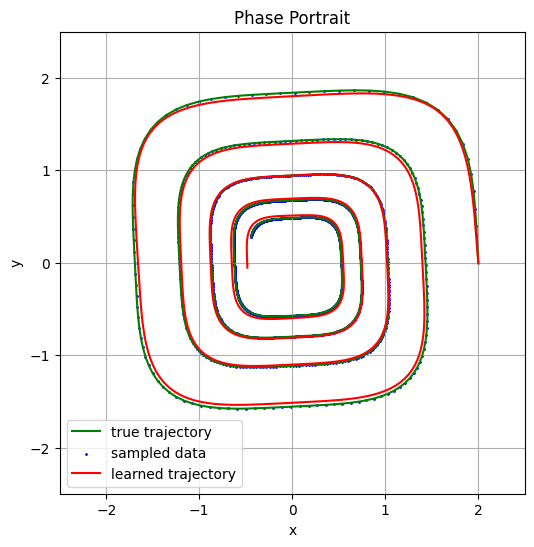

100%|██████████| 401/401 [00:19<00:00, 20.37it/s]

process time: 19.6904296875 sec


In [290]:
## Train
niters = 400

node = NeuralODE(func=ODEFunc()).cuda()
optimizer = optim.RMSprop(node.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = node(y0=batch_y0, t=batch_t, solver=rk4)
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = node(true_y0, t, solver=rk4)
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

4-1. Integrador numérico dopri-5 mediante la biblioteca torchdiffeq

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 8.078062


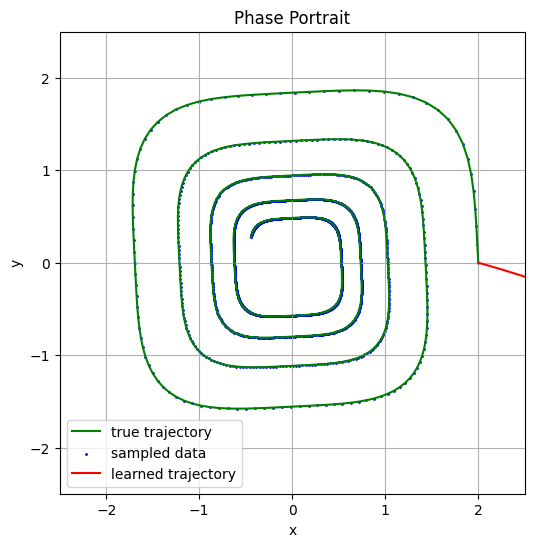

 12%|█▏        | 50/401 [00:02<00:13, 25.82it/s]

Iter 0050 | Total Loss 0.593925


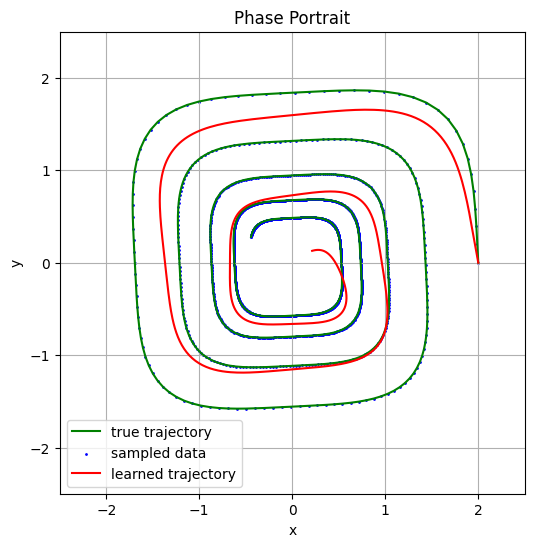

 25%|██▍       | 100/401 [00:05<00:12, 24.69it/s]

Iter 0100 | Total Loss 0.874965


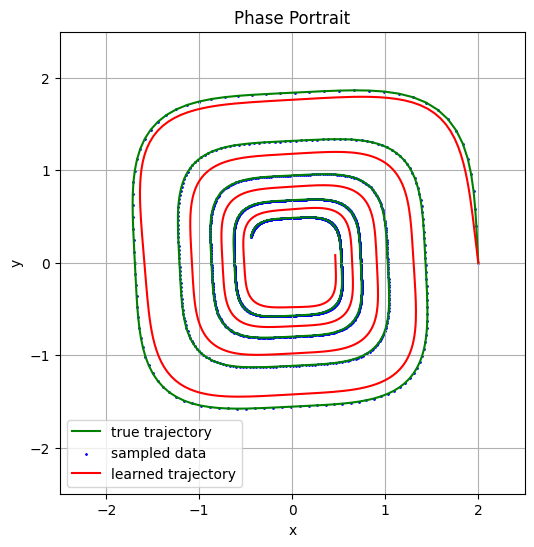

 37%|███▋      | 148/401 [00:09<00:09, 25.71it/s]

Iter 0150 | Total Loss 0.369452


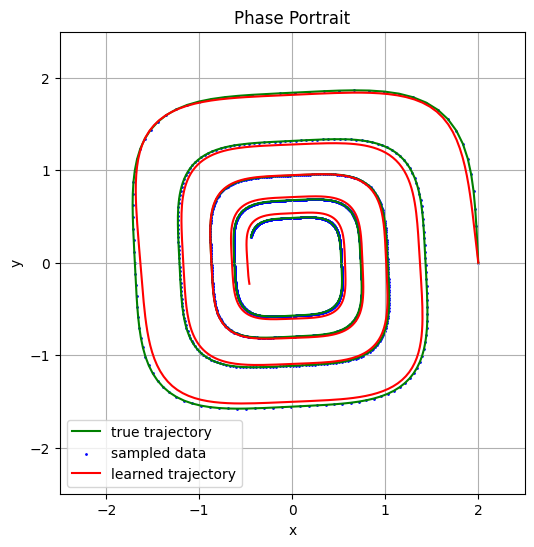

 50%|████▉     | 199/401 [00:13<00:07, 25.57it/s]

Iter 0200 | Total Loss 0.723632


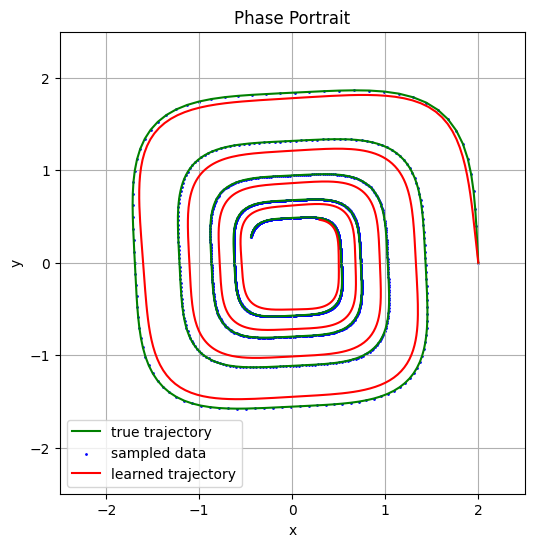

 62%|██████▏   | 250/401 [00:17<00:05, 25.93it/s]

Iter 0250 | Total Loss 0.774149


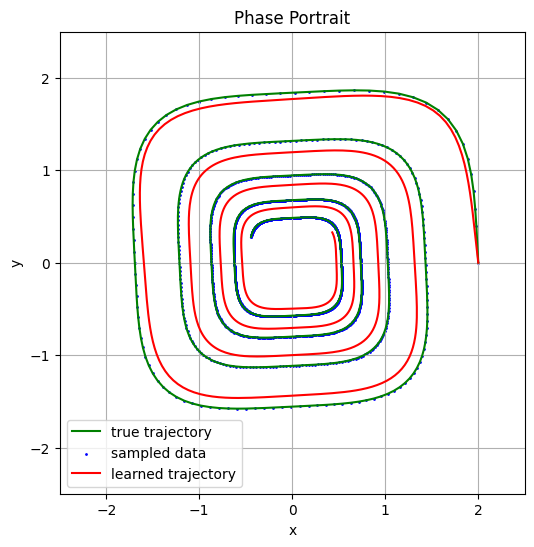

 74%|███████▍  | 298/401 [00:20<00:04, 24.95it/s]

Iter 0300 | Total Loss 0.479500


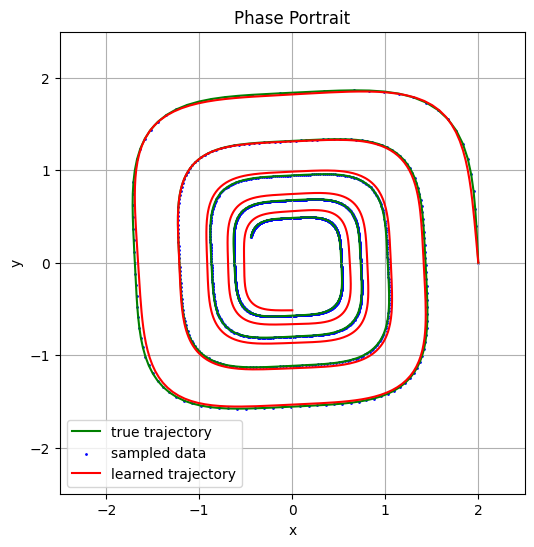

 87%|████████▋ | 349/401 [00:25<00:02, 24.93it/s]

Iter 0350 | Total Loss 0.267086


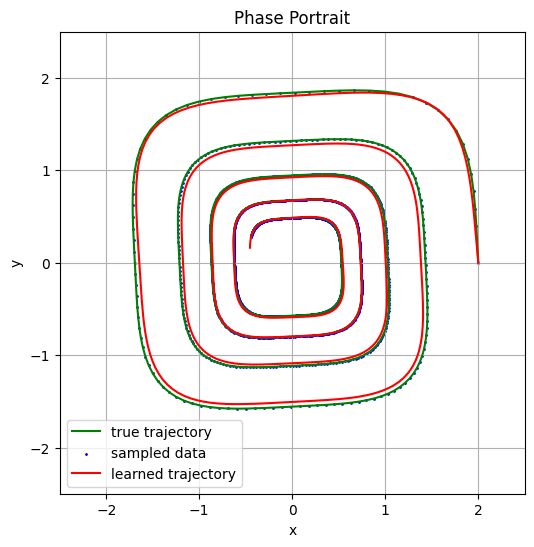

100%|█████████▉| 399/401 [00:29<00:00, 26.35it/s]

Iter 0400 | Total Loss 0.273862


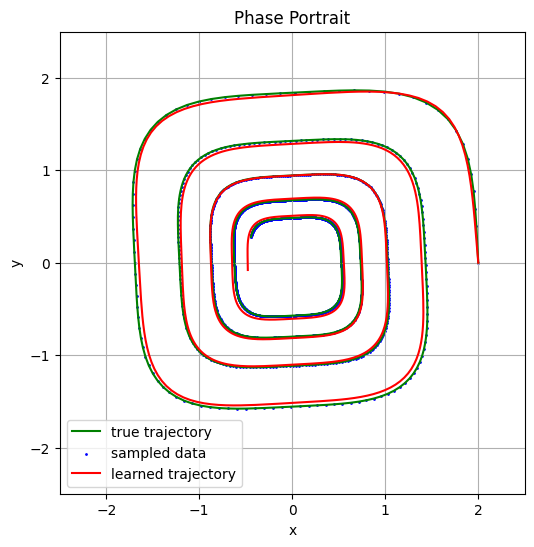

100%|██████████| 401/401 [00:30<00:00, 12.96it/s]

process time: 30.944462776184082 sec


In [291]:
## Train
niters = 400

func = ODEFunc().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))

4-2. Comparación con el Método de Retropropagación Adjunta (Adjoint Backpropagation Method)

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 0.609077


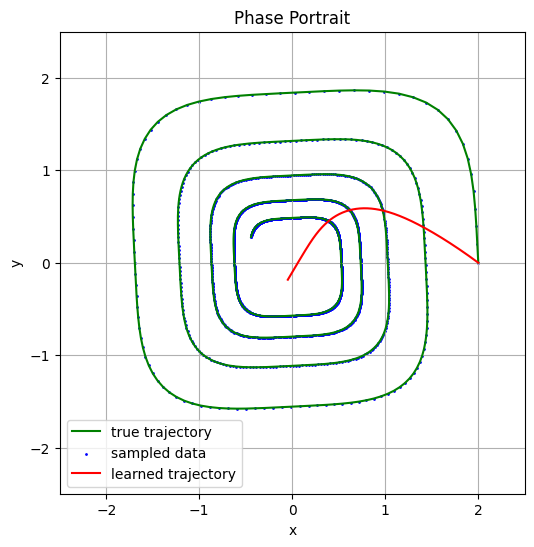

 12%|█▏        | 50/401 [00:08<00:58,  5.97it/s]

Iter 0050 | Total Loss 0.670386


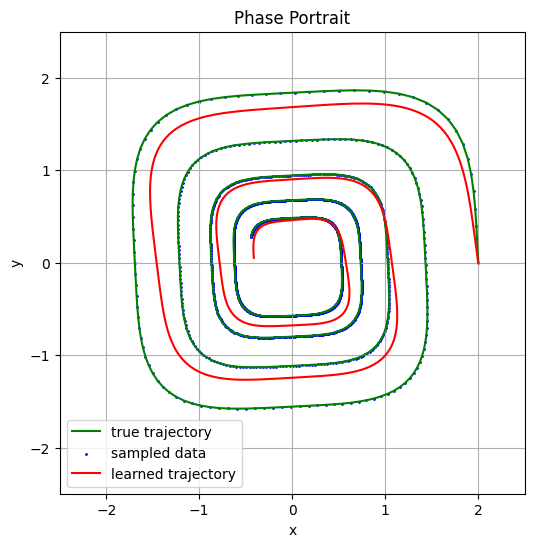

 25%|██▍       | 100/401 [00:18<00:53,  5.60it/s]

Iter 0100 | Total Loss 0.845634


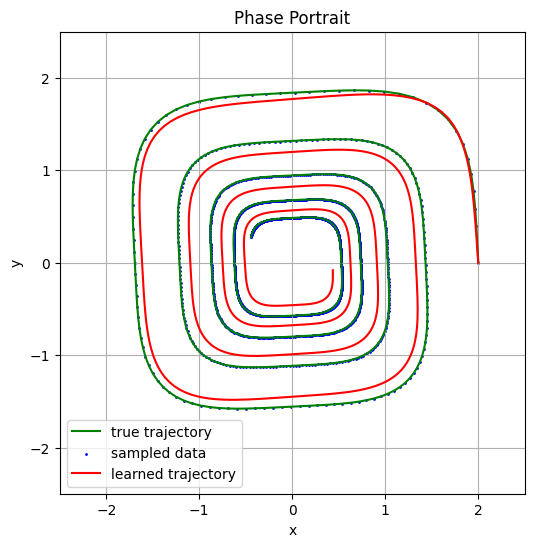

 37%|███▋      | 150/401 [00:30<00:42,  5.96it/s]

Iter 0150 | Total Loss 0.493610


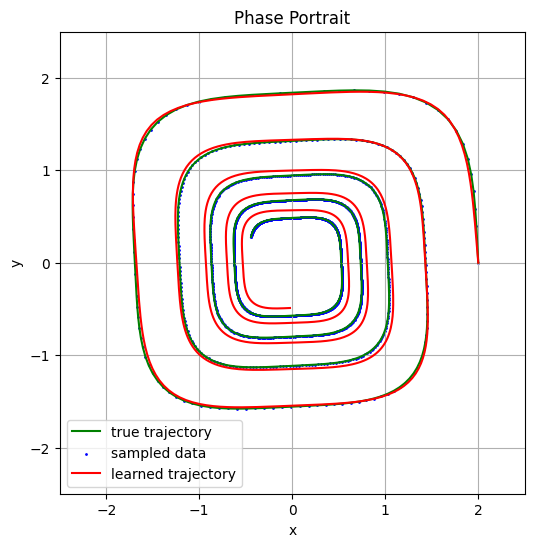

 50%|████▉     | 200/401 [00:42<00:38,  5.28it/s]

Iter 0200 | Total Loss 0.708006


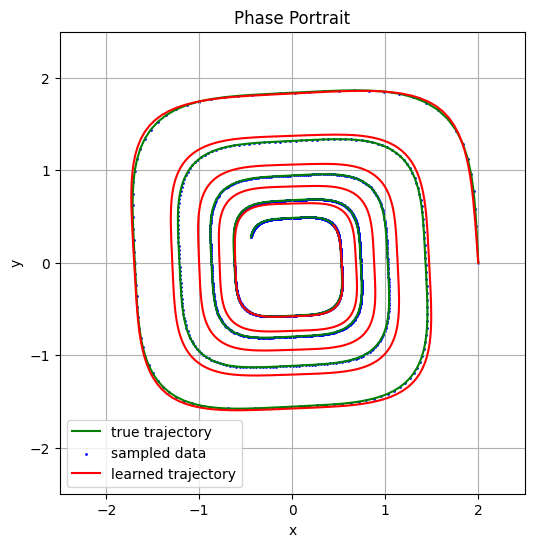

 62%|██████▏   | 250/401 [00:54<00:30,  4.99it/s]

Iter 0250 | Total Loss 0.448591


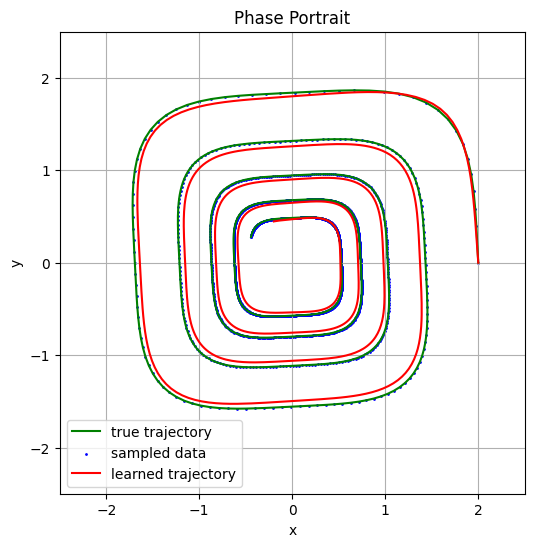

 75%|███████▍  | 300/401 [01:06<00:20,  4.87it/s]

Iter 0300 | Total Loss 0.273083


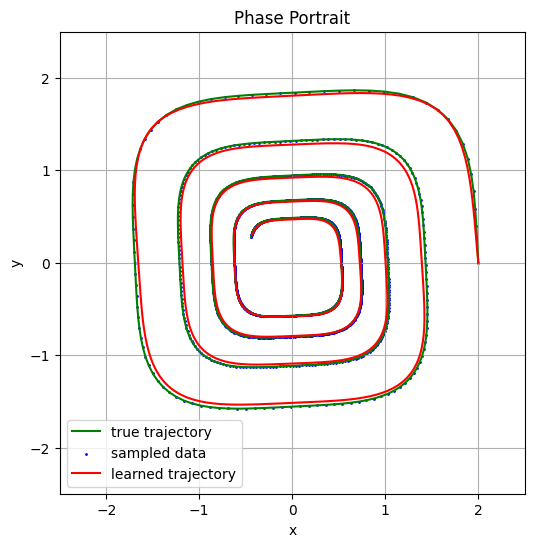

 87%|████████▋ | 350/401 [01:16<00:08,  5.67it/s]

Iter 0350 | Total Loss 0.777531


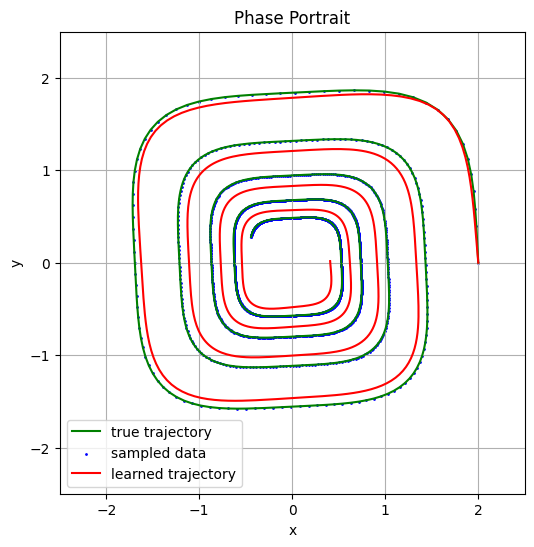

100%|█████████▉| 400/401 [01:27<00:00,  5.96it/s]

Iter 0400 | Total Loss 0.280070


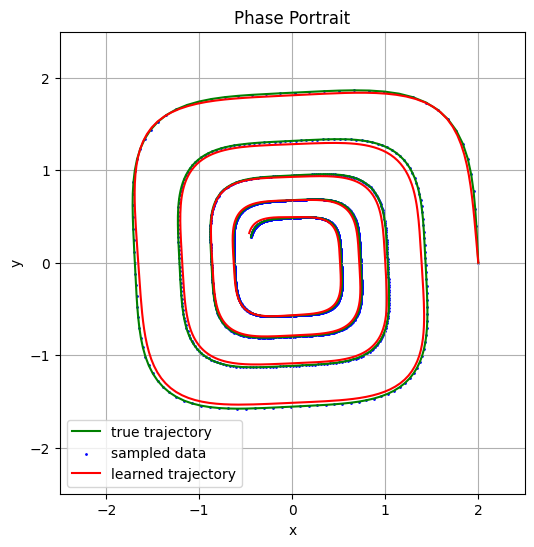

100%|██████████| 401/401 [01:28<00:00,  4.51it/s]

process time: 88.86046934127808 sec


In [292]:
from torchdiffeq import odeint_adjoint

## Train
niters = 400

func = ODEFunc().cuda()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
  optimizer.zero_grad()
  batch_y0, batch_t, batch_y = get_batch()
  pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))
  loss.backward()
  optimizer.step()

  if iter % 50 == 0:
    with torch.no_grad():
      pred_y = odeint_adjoint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
      loss = torch.mean(torch.abs(pred_y - true_y))
      print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
      visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))